# 🤪 Variational Autoencoders - CelebA Faces

In this notebook, we'll walk through the steps required to train your own variational autoencoder on the CelebA faces dataset

**Helper functions:** This code cell defines functions to obtain a random batch of images from a dataset (`sample_batch`) and to display a grid of images (`display`). These functions are used later for quick visualization of training data and results.

In [3]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

**Imports and setup:** This cell imports necessary libraries for building the variational autoencoder, including TensorFlow, Keras, SciPy, and helper functions. It also disables eager execution (via `tf.compat.v1.disable_eager_execution`) to allow certain Keras features to work correctly.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

## 0. Parameters <a name="parameters"></a>

**Hyperparameters:** Here the key hyperparameters for the VAE are defined, including the image size, number of channels, batch size, dimension of the latent space, learning rate, number of training epochs, and the β coefficient that weights the KL‑divergence term in the loss function.

In [5]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

**Loading the data:** This cell uses TensorFlow’s `image_dataset_from_directory` to load the CelebA dataset from disk. It reads unlabeled RGB images, resizes them to the specified `IMAGE_SIZE`, shuffles them, and organizes them into batches for training.

In [6]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "../../../data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files.


**Preprocessing:** A preprocessing function is defined to scale pixel values from integers in `[0, 255]` to floating‑point numbers in `[0, 1]`. The function is applied to the dataset to prepare the images for training.

In [7]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

**Sample a batch:** A random batch of images is sampled from the preprocessed training data. This will later be used for visualization.

In [8]:
train_sample = sample_batch(train)

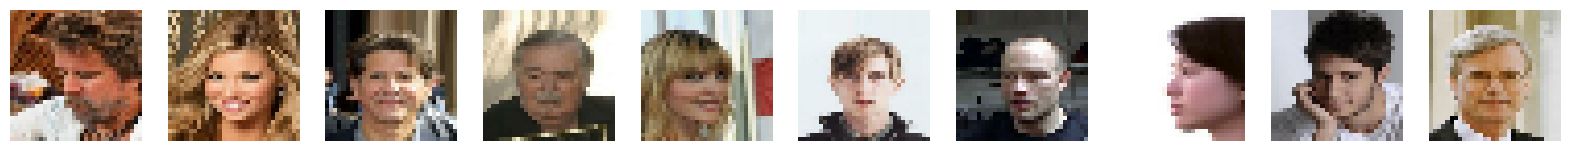

In [9]:
# Show some faces from the training set
display(train_sample, cmap=None)

## 2. Build the variational autoencoder <a name="build"></a>

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Encoder architecture:** This cell sets the latent dimension and defines the `get_encoder` function, which builds the encoder network using convolutional layers. The encoder outputs the mean and log variance of the latent distribution and samples a latent vector using the reparameterization trick. A model summary is printed for inspection.

In [11]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      3,584 │ encoder_input[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │    147,584 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 2, 2, 128) │    147,584 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 2, 2, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    102,600 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 200)       │    102,600 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 200)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 653,584 (2.49 MB)

 Trainable params: 652,560 (2.49 MB)

 Non-trainable params: 1,024 (4.00 KB)

**Decoder architecture:** This cell defines the `get_decoder` function to build the decoder network using transposed convolutions. The decoder takes a latent vector as input and reconstructs an image of the original size. A model summary is printed to show the decoder’s layers.

In [12]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,803 (2.67 MB)

 Trainable params: 698,755 (2.67 MB)

 Non-trainable params: 2,048 (8.00 KB)

**Custom VAE class:** A subclass of `tf.keras.Model` named `VAE` is implemented here. It encapsulates the encoder and decoder, defines the forward pass (`call`), implements a custom `train_step` to compute reconstruction and KL‑divergence losses (weighted by β), and maintains training metrics.

In [13]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * tf.reduce_mean(tf.square(data - reconstruction), axis=[1,2,3])
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * tf.reduce_mean(tf.square(data - reconstruction), axis=[1,2,3])
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

**Instantiate the VAE:** The VAE model is constructed by passing the encoder and decoder instances into the custom `VAE` class. This prepares the model for compilation and training.

In [14]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

**Compile the model:** The VAE is built with the specified input shape and compiled using the Adam optimizer with the defined learning rate. This prepares the model for training.

In [15]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

**Training callbacks:** Various callbacks are defined: a `ModelCheckpoint` to save model weights after each epoch, a `TensorBoard` callback for logging metrics, and a custom `ImageGenerator` callback that generates and saves sample images after each epoch using random latent vectors.

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

**Load existing weights (optional):** This cell optionally loads previously saved model weights if the `LOAD_MODEL` flag is set and the model file exists, allowing training to resume from a checkpoint.

In [17]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

**Train the VAE:** The model is trained on the dataset for the specified number of epochs using the defined callbacks. Training progress and metrics are recorded, and sample images are generated during training.

In [18]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 725s 455ms/step - kl_loss: 15.9414 - loss: 79.2301 - reconstruction_loss: 63.2886
Epoch 2/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 641s 405ms/step - kl_loss: 16.1501 - loss: 67.9039 - reconstruction_loss: 51.7537
Epoch 3/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 516s 326ms/step - kl_loss: 16.7670 - loss: 65.8182 - reconstruction_loss: 49.0511
Epoch 4/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 498s 315ms/step - kl_loss: 16.9667 - loss: 65.0646 - reconstruction_loss: 48.0980
Epoch 5/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 490s 309ms/step - kl_loss: 17.0904 - loss: 64.6753 - reconstruction_loss: 47.5851
Epoch 6/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 523s 330ms/step - kl_loss: 17.1546 - loss: 64.3553 - reconstruction_loss: 47.2007
Epoch 7/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 512s 324ms/step - kl_loss: 17.2261 - loss: 64.1250 - reconstruction_loss: 46.8989
Epoch 8/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 492s 311ms/step - kl_loss: 17.3116 - loss: 63.8268 - reconstruction_loss: 46.5152
Epoch 9/

**Save trained models:** After training, this cell saves the entire VAE as well as its encoder and decoder components to disk. These saved models can be reloaded later for inference or further training.

In [25]:
# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

**Select evaluation images:** A subset of images is selected from the training data to visualize the VAE’s reconstruction capability on unseen examples.

In [26]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

**Reconstruct images:** The selected images are encoded into latent vectors, decoded back to images, and displayed alongside the originals to compare the quality of reconstructions produced by the VAE.

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Example real faces


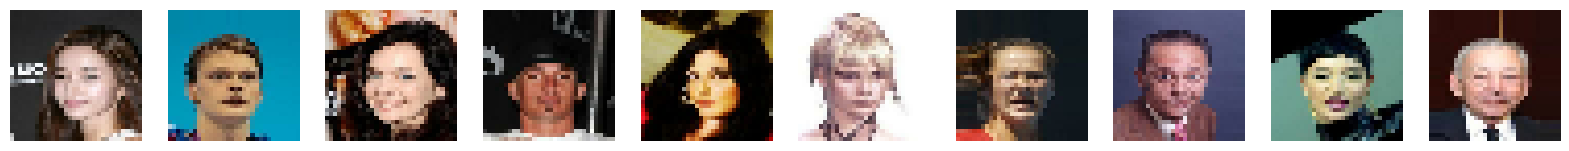

Reconstructions


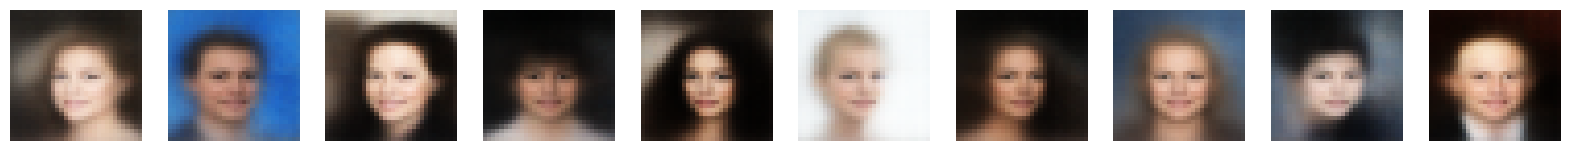

In [27]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Latent space distribution

**Latent distribution analysis:** This cell encodes the selected images to latent vectors, plots histograms for the first 50 latent dimensions, and overlays the probability density function of a standard normal distribution to assess how well the latent distribution matches the prior.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


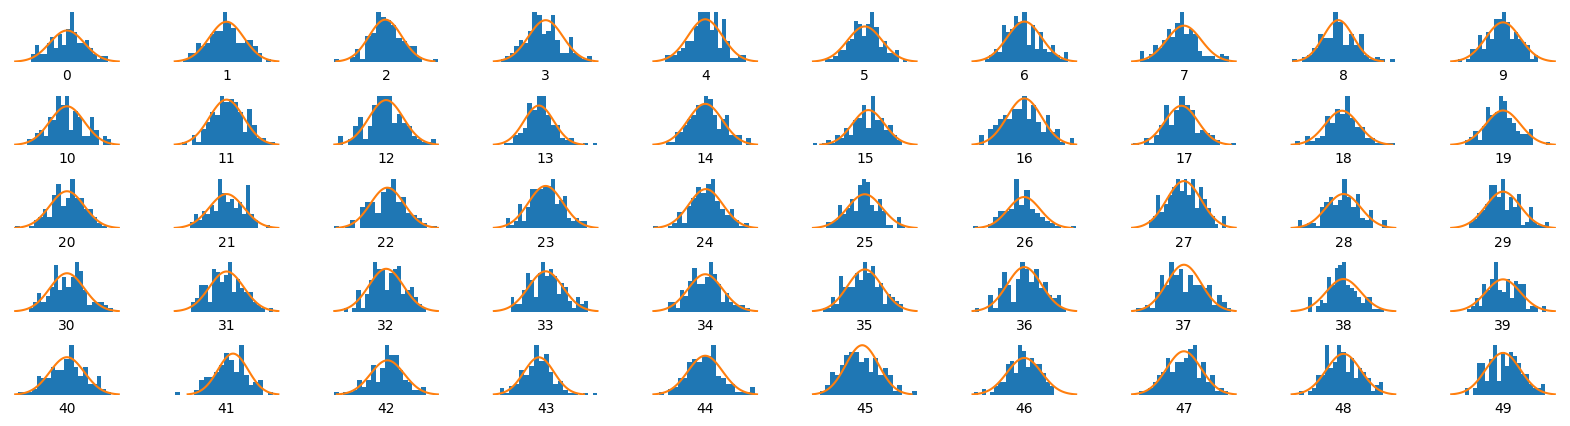

In [28]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

**Sample random latent vectors:** A set of random vectors is drawn from a standard normal distribution to explore the generative capabilities of the VAE in latent space.

In [29]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

**Decode random samples:** The randomly sampled latent vectors are decoded into images using the trained decoder, producing entirely new faces.

In [30]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


**Visualize generated faces:** The decoded images are arranged in a grid to showcase the diversity of synthetic faces generated from random latent vectors.

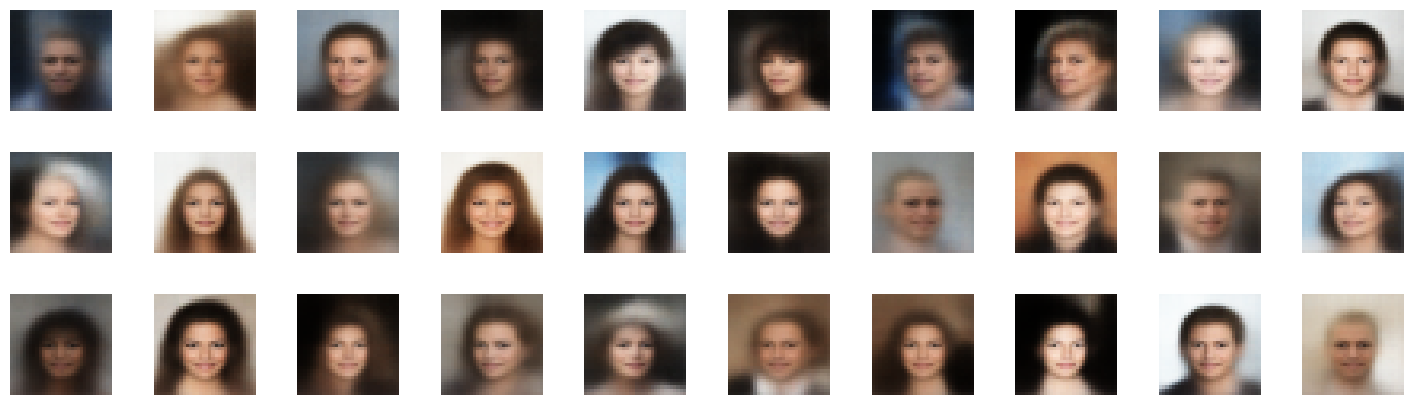

In [31]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

**Load attribute labels:** The CelebA attribute file (`list_attr_celeba.csv`) is loaded to access binary labels for various facial attributes. The attribute names are printed to identify available traits for manipulation.

In [33]:
# Load the label dataset
attributes = pd.read_csv("../../../data/celeba-dataset/list_attr_celeba.csv")     
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**Build a labelled dataset:** A `tf.data.Dataset` is created that pairs images with a chosen binary attribute (e.g., `Blond_Hair`) using the attribute CSV file. The images are preprocessed, and the labels are extracted to facilitate attribute‑based latent vector calculations.

In [39]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
     "../../../data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


**Compute an attribute vector:** Using the labelled dataset, this cell computes a latent direction vector associated with the selected attribute by averaging the difference between latent encodings of images with and without the attribute. This vector captures how moving in latent space changes the presence of the attribute.

In [40]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.223    : 1.551    : 3.664    : 3.664
44    : 2.254    : 1.038    : 2.726    : -0.938
65    : 1.266    : 0.547    : 2.253    : -0.474
87    : 0.877    : 0.382    : 2.025    : -0.228
110    : 0.672    : 0.3    : 1.92    : -0.104
128    : 0.498    : 0.254    : 1.922    : 0.002
150    : 0.449    : 0.213    : 1.857    : -0.065
171    : 0.389    : 0.2    : 1.825    : -0.032
197    : 0.376    : 0.16    : 1.757    : -0.068
218    : 0.311    : 0.152    : 1.732    : -0.025
241    : 0.281    : 0.125    : 1.676    : -0.056
260    : 0.242    : 0.113    : 1.679    : 0.003
282    : 0.224    : 0.118    : 1.668    : -0.012
302    : 0.204    : 0.097    : 1.64    : -0.027
317    : 0.175    : 0.089    : 1.611    : -0.029
337    : 0.192    : 0.083    : 1.596    : -0.016
356    : 0.166    : 0.085    : 1.577    : -0.019
377    : 0.173    : 0.083    : 1.563    : -0.014
395    : 0.149    : 0.077    : 1.559    : -0.004
415    : 0.15

**Modify images by adding the attribute:** The computed attribute vector is added to latent encodings of images to modify them along the chosen attribute dimension (for example, adding `Blond_Hair`). The resulting images are displayed to demonstrate the effect.

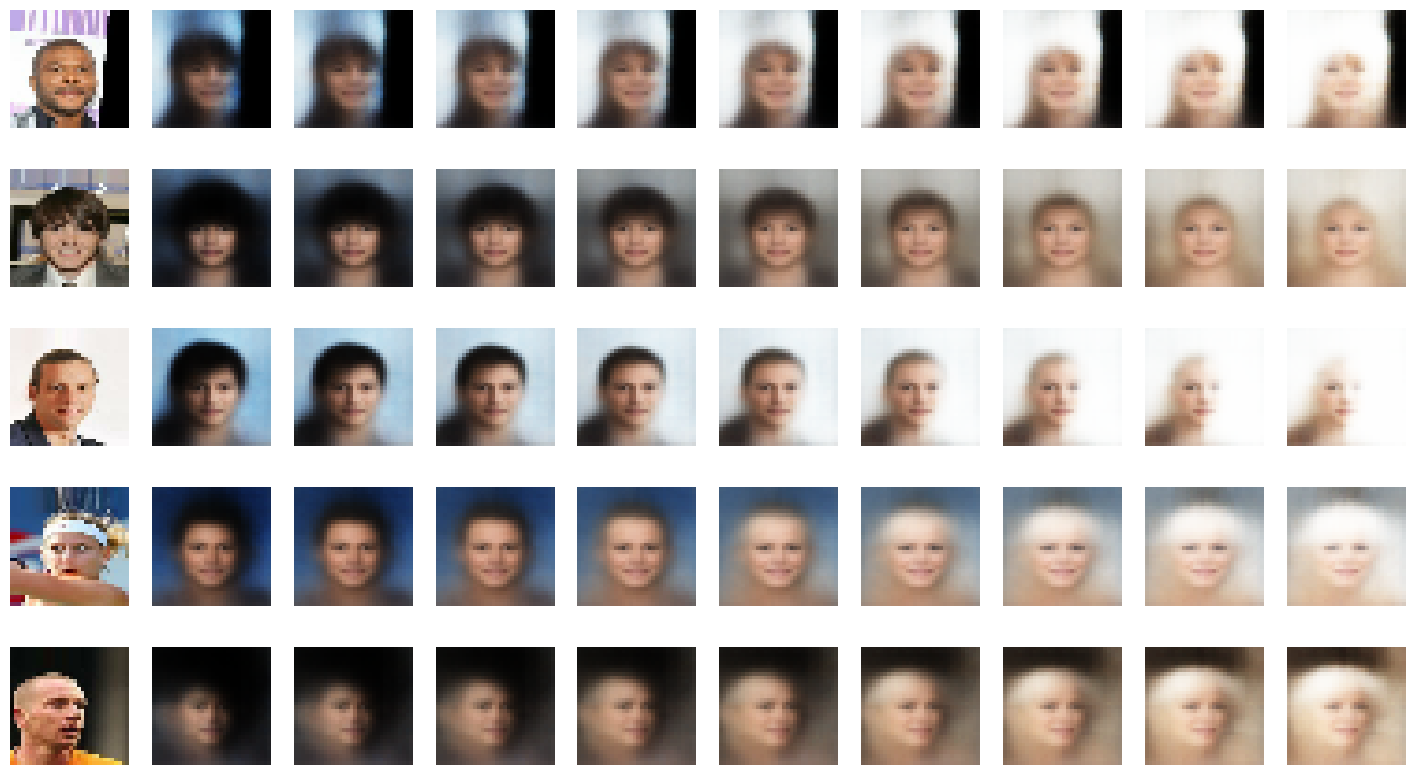

In [41]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

**Morph between faces:** This cell selects two images from the labelled dataset and performs linear interpolation between their latent representations. The `morph_faces` function generates intermediate images illustrating a smooth morph between the two faces.

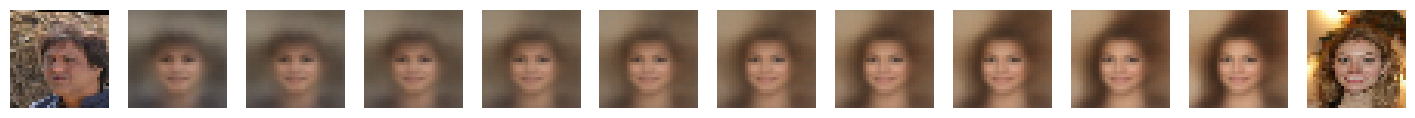

In [42]:
morph_faces(labelled, vae)